In [1]:
%cd ../..

/home/dmoreno/ATAT_ZTF/elasticc_one


# Confusion matrices

In [2]:
import os
import json 
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

/home/dmoreno/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
path_data = './data/final/ZTF_ff/LC_MD_FEAT_v2_windows'
path_results = './results/ZTF/LC_MD_FEAT/prueba_lc_md_feat_mta_v2_windows/MTA'
time_to_eval = 2048

order_classes = ['SNIa', # yes
                 'SNIbc', # yes
                 'SNIIb', # yes
                 'SNII', # yes
                 'SNIIn', # yes
                 'SLSN', # yes
                 'TDE', # yes
                 'Microlensing', # yes
                 'QSO', 
                 'AGN', # yes
                 'Blazar', 
                 'YSO', 
                 'CV/Nova', 
                 'LPV', 
                 'EA', 
                 'EB/EW', # yes
                 'Periodic-Other', 
                 'RSCVn', 
                 'CEP', 
                 'RRLab', 
                 'RRLc', 
                 'DSCT']

In [5]:
objects_partitions = pd.read_parquet('./data/partitions/v2/partitions.parquet')
obj_label = objects_partitions[objects_partitions['partition'] == 'test']
y_real_test = obj_label['alerceclass'].values
obj_label = ['aid_{}'.format(x) for x in obj_label['oid'].values]
obj_label

['aid_ZTF19abpidqn',
 'aid_ZTF18acermlg',
 'aid_ZTF18absxqzn',
 'aid_ZTF19adhgywz',
 'aid_ZTF20aalmrrd',
 'aid_ZTF18acbuyhj',
 'aid_ZTF18adldhip',
 'aid_ZTF19aamwrjt',
 'aid_ZTF22aaaifbj',
 'aid_ZTF18acbyyff',
 'aid_ZTF18abjsqai',
 'aid_ZTF18aacvllp',
 'aid_ZTF21acilpzw',
 'aid_ZTF20aayxldg',
 'aid_ZTF18abeeqll',
 'aid_ZTF17aacksnj',
 'aid_ZTF18abcvvxj',
 'aid_ZTF18absqkvk',
 'aid_ZTF18ababjtt',
 'aid_ZTF18acrvtdw',
 'aid_ZTF18aaadqzg',
 'aid_ZTF19acekcsg',
 'aid_ZTF19aamudfg',
 'aid_ZTF18adnchgh',
 'aid_ZTF20abpkdwn',
 'aid_ZTF18aagtdhv',
 'aid_ZTF18aazroen',
 'aid_ZTF18acrjptm',
 'aid_ZTF20aaxxwfh',
 'aid_ZTF18aaywgkj',
 'aid_ZTF18aauylxe',
 'aid_ZTF18aakdimq',
 'aid_ZTF18aayhgef',
 'aid_ZTF19abxjrge',
 'aid_ZTF19abnqhwd',
 'aid_ZTF18aaoasno',
 'aid_ZTF18aaaruql',
 'aid_ZTF18acvgnvd',
 'aid_ZTF18abmdnza',
 'aid_ZTF19aadgbbd',
 'aid_ZTF18abcblkf',
 'aid_ZTF18abmnxjj',
 'aid_ZTF17aabuyxz',
 'aid_ZTF19acexkfl',
 'aid_ZTF20abjubxo',
 'aid_ZTF19ablpqvk',
 'aid_ZTF20abjuete',
 'aid_ZTF22ab

In [6]:
y_real_test.shape

(8350,)

In [7]:
len(obj_label)

8350

In [8]:
import yaml

def load_yaml(path):
    with open(path, 'r') as file:
        args = yaml.load(file, Loader=yaml.FullLoader)
    return args

dict_info = load_yaml('{}/dict_info.yaml'.format(path_data))

mapping_classes = dict_info['mapping_classes']
mapping_classes_inverted = {v: k for k, v in mapping_classes.items()}
print(mapping_classes_inverted)

{5: 'AGN', 15: 'Blazar', 11: 'CEP', 14: 'CV/Nova', 1: 'DSCT', 12: 'EA', 2: 'EB/EW', 7: 'LPV', 21: 'Microlensing', 13: 'Periodic-Other', 3: 'QSO', 10: 'RRLab', 8: 'RRLc', 4: 'RSCVn', 18: 'SLSN', 19: 'SNII', 16: 'SNIIb', 0: 'SNIIn', 6: 'SNIa', 20: 'SNIbc', 17: 'TDE', 9: 'YSO'}


In [9]:
def sort_dict_by_value(d, reverse=False):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=reverse))

sort_classes = list(sort_dict_by_value(mapping_classes).keys())
print(sort_classes)

['SNIIn', 'DSCT', 'EB/EW', 'QSO', 'RSCVn', 'AGN', 'SNIa', 'LPV', 'RRLc', 'YSO', 'RRLab', 'CEP', 'EA', 'Periodic-Other', 'CV/Nova', 'Blazar', 'SNIIb', 'TDE', 'SLSN', 'SNII', 'SNIbc', 'Microlensing']


In [10]:
predictions = torch.load('{}/all_predictions_times.pt'.format(path_results))
predictions

{'SNID': array([b'ZTF17aaaecgi_0', b'ZTF17aaaecgi_1', b'ZTF17aaaecgi_2', ...,
        b'ZTF23abcvqkd_3', b'ZTF23abcvqkd_4', b'ZTF23abcvqkd_5'],
       dtype=object),
 'y_test': tensor([2, 2, 2,  ..., 6, 6, 6]),
 'list_y_pred': {'test_16': array([12,  2,  2, ..., 19, 19, 19]),
  'test_32': array([ 2,  2,  2, ..., 19, 16,  6]),
  'test_64': array([ 2,  2,  2, ..., 19, 19,  6]),
  'test_128': array([ 2,  2,  2, ..., 19, 19,  6]),
  'test_256': array([ 2,  2,  2, ..., 19, 19,  6]),
  'test_512': array([ 2,  2,  2, ..., 19,  6,  6]),
  'test_1024': array([ 2,  2,  2, ..., 19,  6,  6]),
  'test_2048': array([2, 2, 2, ..., 6, 6, 6])},
 'list_y_pred_prob': {'test_16': array([[6.6730954e-11, 1.0940837e-03, 3.1876701e-01, ..., 4.3237228e-10,
          6.9853623e-10, 1.2553594e-11],
         [1.1172583e-10, 7.6153030e-04, 6.7463577e-01, ..., 9.0121979e-11,
          3.1843755e-10, 5.5606761e-12],
         [3.4219034e-11, 2.4041331e-03, 7.4660689e-01, ..., 4.0153336e-11,
          3.3124371e-11, 4

In [11]:
# Procesamiento para agregar los índices correspondientes
from itertools import groupby

# Convertir bytes a str para facilitar la manipulación
snids_str = [snid.decode("utf-8") for snid in predictions['SNID']]

# Función para extraer el identificador base de cada SNID
def base_id(snid):
    return "_".join(snid.split("_")[:-1])

# Agrupar por el identificador base
grouped = groupby(range(len(snids_str)), key=lambda x: base_id(snids_str[x]))

# Crear la nueva clave con los índices agrupados
idx_windows_objects = [list(group) for _, group in grouped]

# Crear la clave 'idx_unique_y_test' con los índices del SNID 0 de todos los objetos
idx_unique_y_test = []
ids_unique_real = []

for i, snid in enumerate(snids_str):
    if snid.endswith("_0"):
        idx_unique_y_test.append(i)
        ids_unique_real.append('aid_{}'.format(snid.split('_')[0]))

# Mostrar el resultado
print('length: ', len(idx_windows_objects))
print('length: ', len(idx_unique_y_test))

length:  41747
length:  41747


In [12]:
print(ids_unique_real)
print(len(ids_unique_real))

['aid_ZTF17aaaecgi', 'aid_ZTF17aaaedvi', 'aid_ZTF17aaafglk', 'aid_ZTF17aaafiut', 'aid_ZTF17aaafiww', 'aid_ZTF17aaafyis', 'aid_ZTF17aaafyxs', 'aid_ZTF17aaagryq', 'aid_ZTF17aaaidzt', 'aid_ZTF17aaaizfv', 'aid_ZTF17aaakbvl', 'aid_ZTF17aaaorgv', 'aid_ZTF17aaaowhs', 'aid_ZTF17aaaqtul', 'aid_ZTF17aaarxab', 'aid_ZTF17aaarxbz', 'aid_ZTF17aaarzye', 'aid_ZTF17aaasboc', 'aid_ZTF17aaasklh', 'aid_ZTF17aaatgma', 'aid_ZTF17aaatkxt', 'aid_ZTF17aaatlhi', 'aid_ZTF17aaauijj', 'aid_ZTF17aaaweng', 'aid_ZTF17aaawqzp', 'aid_ZTF17aabhlnm', 'aid_ZTF17aabooqt', 'aid_ZTF17aabootn', 'aid_ZTF17aabopzp', 'aid_ZTF17aaboqfs', 'aid_ZTF17aabppsz', 'aid_ZTF17aabppwh', 'aid_ZTF17aabqidu', 'aid_ZTF17aabummz', 'aid_ZTF17aabupde', 'aid_ZTF17aabuphg', 'aid_ZTF17aabuuyx', 'aid_ZTF17aabuvjm', 'aid_ZTF17aabvgfc', 'aid_ZTF17aabviic', 'aid_ZTF17aabxamk', 'aid_ZTF17aabxkhe', 'aid_ZTF17aacgwpq', 'aid_ZTF17aackses', 'aid_ZTF17aactvce', 'aid_ZTF17aadgwyo', 'aid_ZTF17aadidmw', 'aid_ZTF17aadjkhd', 'aid_ZTF17aadooax', 'aid_ZTF18aaaajiw',

In [13]:
# Calcular el promedio de las probabilidades para cada conjunto de ventanas

predictions.update({
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    })

for eval_time, predicciones in predictions['list_y_pred_prob'].items():
    predictions['list_y_pred_prob_avg'][eval_time] = [] 
    predictions['list_y_pred_avg'][eval_time] = [] 
    for idx_windows in idx_windows_objects:
        window_probs = predicciones[idx_windows]
        avg_probs = np.mean(window_probs, axis=0)
        predictions['list_y_pred_prob_avg'][eval_time].append(avg_probs)
        predictions['list_y_pred_avg'][eval_time].append(np.argmax(avg_probs, axis=0))

    predictions['list_y_pred_prob_avg'][eval_time] = np.array(predictions['list_y_pred_prob_avg'][eval_time])
    predictions['list_y_pred_avg'][eval_time] = np.array(predictions['list_y_pred_avg'][eval_time])

predictions['list_y_pred_avg']

{'test_16': array([ 2,  7, 14, ...,  6,  6, 19]),
 'test_32': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_64': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_128': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_256': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_512': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_1024': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_2048': array([ 2,  7, 14, ...,  0,  6,  6])}

In [14]:
predictions['list_y_pred_avg']['test_2048'].shape

(41747,)

In [15]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg'])

In [16]:
predictions['y_test'].shape

torch.Size([252921])

In [17]:
predictions['SNID'].shape

(252921,)

In [18]:
print(idx_unique_y_test)

[0, 8, 16, 21, 30, 38, 46, 54, 57, 62, 67, 74, 80, 84, 96, 101, 106, 113, 119, 124, 128, 132, 139, 144, 155, 164, 168, 177, 189, 200, 209, 218, 227, 235, 245, 255, 263, 271, 279, 288, 295, 304, 310, 314, 319, 320, 325, 330, 334, 338, 341, 347, 354, 363, 370, 377, 384, 392, 395, 402, 408, 415, 422, 430, 438, 445, 453, 462, 472, 479, 488, 494, 500, 504, 511, 515, 530, 543, 548, 554, 561, 572, 585, 597, 610, 622, 635, 642, 654, 662, 671, 678, 693, 706, 713, 719, 724, 734, 742, 746, 756, 772, 781, 788, 794, 802, 811, 819, 826, 835, 843, 847, 859, 867, 879, 894, 898, 907, 915, 922, 930, 939, 946, 953, 961, 970, 979, 988, 997, 1009, 1012, 1019, 1031, 1040, 1051, 1059, 1066, 1074, 1081, 1090, 1097, 1101, 1109, 1117, 1128, 1133, 1140, 1152, 1163, 1170, 1181, 1184, 1192, 1199, 1207, 1211, 1221, 1234, 1241, 1251, 1260, 1267, 1277, 1281, 1289, 1295, 1304, 1310, 1318, 1324, 1328, 1332, 1338, 1350, 1356, 1361, 1368, 1375, 1384, 1392, 1398, 1405, 1413, 1418, 1426, 1434, 1446, 1453, 1459, 1465, 1473,

In [19]:
print(ids_unique_real)

['aid_ZTF17aaaecgi', 'aid_ZTF17aaaedvi', 'aid_ZTF17aaafglk', 'aid_ZTF17aaafiut', 'aid_ZTF17aaafiww', 'aid_ZTF17aaafyis', 'aid_ZTF17aaafyxs', 'aid_ZTF17aaagryq', 'aid_ZTF17aaaidzt', 'aid_ZTF17aaaizfv', 'aid_ZTF17aaakbvl', 'aid_ZTF17aaaorgv', 'aid_ZTF17aaaowhs', 'aid_ZTF17aaaqtul', 'aid_ZTF17aaarxab', 'aid_ZTF17aaarxbz', 'aid_ZTF17aaarzye', 'aid_ZTF17aaasboc', 'aid_ZTF17aaasklh', 'aid_ZTF17aaatgma', 'aid_ZTF17aaatkxt', 'aid_ZTF17aaatlhi', 'aid_ZTF17aaauijj', 'aid_ZTF17aaaweng', 'aid_ZTF17aaawqzp', 'aid_ZTF17aabhlnm', 'aid_ZTF17aabooqt', 'aid_ZTF17aabootn', 'aid_ZTF17aabopzp', 'aid_ZTF17aaboqfs', 'aid_ZTF17aabppsz', 'aid_ZTF17aabppwh', 'aid_ZTF17aabqidu', 'aid_ZTF17aabummz', 'aid_ZTF17aabupde', 'aid_ZTF17aabuphg', 'aid_ZTF17aabuuyx', 'aid_ZTF17aabuvjm', 'aid_ZTF17aabvgfc', 'aid_ZTF17aabviic', 'aid_ZTF17aabxamk', 'aid_ZTF17aabxkhe', 'aid_ZTF17aacgwpq', 'aid_ZTF17aackses', 'aid_ZTF17aactvce', 'aid_ZTF17aadgwyo', 'aid_ZTF17aadidmw', 'aid_ZTF17aadjkhd', 'aid_ZTF17aadooax', 'aid_ZTF18aaaajiw',

In [20]:
predictions['labels_final'] = predictions['y_test'][idx_unique_y_test]
predictions['ids_final'] = np.array(ids_unique_real)
print(predictions['labels_final'].shape)

df_atat_pred = []

for eval_time, prob_classes in predictions['list_y_pred_prob_avg'].items():
    df = pd.DataFrame(prob_classes, columns=sort_classes)
    df['shorten'] = str(eval_time.split('_')[-1])
    df.index = predictions['ids_final']
    df_atat_pred.append(df)

df_atat_pred = pd.concat(df_atat_pred)
df_atat_pred

torch.Size([41747])


,SNIIn,DSCT,EB/EW,QSO,RSCVn,AGN,SNIa,LPV,RRLc,YSO,...,Periodic-Other,CV/Nova,Blazar,SNIIb,TDE,SLSN,SNII,SNIbc,Microlensing,shorten
aid_ZTF17aaaecgi,8.621186e-11,1.865358e-03,7.042486e-01,3.006795e-09,2.654915e-05,2.196248e-09,2.200397e-08,1.315077e-04,3.730353e-02,2.517540e-03,...,3.761623e-09,0.000148,3.976993e-08,4.092856e-11,9.721791e-12,4.132897e-13,2.166471e-10,1.645837e-10,8.955909e-12,16
aid_ZTF17aaaedvi,1.072011e-13,1.236473e-06,9.215869e-05,1.619814e-10,7.992148e-06,3.254711e-09,8.938059e-08,9.386634e-01,3.445221e-07,2.223863e-03,...,9.718330e-09,0.000048,6.689078e-09,2.017575e-14,1.021311e-13,1.638419e-11,1.335537e-10,6.539570e-10,8.033533e-08,16
aid_ZTF17aaafglk,4.358064e-07,8.733629e-03,2.510797e-02,1.289369e-05,1.294441e-02,1.343563e-06,7.132211e-06,1.769105e-05,2.423440e-02,1.198636e-03,...,2.190019e-01,0.613358,7.665694e-05,4.868935e-06,3.101646e-09,3.504788e-10,1.479459e-05,3.101426e-07,1.090756e-07,16
aid_ZTF17aaafiut,2.372409e-07,1.059908e-02,1.475355e-01,3.615968e-07,2.339690e-03,1.150631e-07,2.690745e-07,1.442962e-04,4.198857e-02,1.438987e-03,...,6.522559e-05,0.000450,1.553036e-06,2.762989e-06,2.650521e-09,7.363618e-11,4.023001e-07,3.743979e-06,4.229159e-09,16
aid_ZTF17aaafiww,3.718543e-09,3.142492e-02,5.512598e-01,9.302507e-07,1.393322e-02,1.453600e-07,7.121640e-08,6.031176e-05,3.575020e-02,5.414172e-04,...,6.266891e-03,0.002872,3.499763e-06,5.822763e-08,8.463377e-09,1.917114e-11,1.510272e-08,1.209108e-07,5.493116e-08,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF23aamapva,2.925186e-12,1.394952e-02,3.218171e-03,2.980430e-08,2.898218e-04,3.788990e-08,2.304414e-08,8.148200e-09,2.829802e-03,8.689707e-07,...,9.787505e-01,0.000026,7.529196e-08,3.892293e-10,1.363794e-09,6.735492e-10,1.145797e-08,1.241588e-10,4.876215e-12,2048
aid_ZTF23aamsarj,1.705089e-03,2.342255e-10,8.684578e-09,1.934237e-07,4.403585e-09,2.035981e-07,2.192224e-01,2.060341e-08,9.034399e-09,2.765271e-08,...,4.498422e-12,0.000560,1.317509e-08,1.071191e-03,1.806530e-11,1.756327e-09,2.347465e-01,5.426936e-01,3.347768e-10,2048
aid_ZTF23aamxeoe,9.970072e-01,3.058001e-10,6.102794e-09,2.339712e-08,1.086036e-10,7.606796e-08,6.445833e-04,6.864291e-09,3.747367e-08,1.475133e-09,...,5.333620e-10,0.000006,1.206604e-08,4.179742e-11,3.508996e-08,4.455800e-07,2.341249e-03,3.576717e-08,4.125571e-12,2048
aid_ZTF23aavxvsz,1.283937e-13,1.801591e-07,1.074269e-06,2.104984e-08,1.108290e-04,5.655727e-06,9.992450e-01,9.883021e-08,2.786982e-08,3.365617e-04,...,8.372393e-10,0.000071,4.540444e-05,4.530097e-07,1.293805e-06,1.388364e-11,1.580317e-04,1.321640e-06,1.143277e-09,2048


In [21]:
atat_pred_2048_time_test = df_atat_pred[df_atat_pred['shorten'] == '2048']
atat_pred_2048_time_test = atat_pred_2048_time_test.reindex(obj_label)[sort_classes]
atat_pred_2048_time_test

,SNIIn,DSCT,EB/EW,QSO,RSCVn,AGN,SNIa,LPV,RRLc,YSO,...,EA,Periodic-Other,CV/Nova,Blazar,SNIIb,TDE,SLSN,SNII,SNIbc,Microlensing
aid_ZTF19abpidqn,3.885245e-04,2.639520e-09,8.289938e-08,2.922109e-05,2.579533e-08,1.215892e-05,9.381331e-01,7.373337e-06,1.480529e-07,5.889269e-05,...,2.853654e-06,1.416602e-10,6.586795e-03,3.678001e-06,2.147802e-09,1.416284e-15,1.786957e-09,8.769270e-03,4.600439e-02,1.957661e-11
aid_ZTF18acermlg,4.421685e-13,9.999989e-01,2.407069e-08,1.805540e-13,2.776838e-08,1.228605e-13,5.094474e-13,2.273589e-12,9.807802e-07,1.331048e-10,...,9.269181e-09,1.222929e-09,1.975247e-08,3.794797e-13,1.427747e-13,1.198783e-16,2.435244e-14,7.662477e-13,1.145000e-13,4.194191e-20
aid_ZTF18absxqzn,5.593110e-08,1.724183e-02,8.814577e-01,8.348268e-09,6.469315e-05,1.075323e-09,1.641435e-10,3.448177e-06,9.077439e-02,1.346624e-05,...,7.775522e-03,4.823779e-08,1.721314e-05,6.143033e-08,9.271213e-09,1.715153e-10,4.475384e-12,1.618688e-10,5.135464e-09,2.457494e-12
aid_ZTF19adhgywz,8.286125e-14,2.478009e-09,3.999578e-09,7.825343e-01,4.136660e-06,2.040554e-01,7.451371e-07,2.112274e-07,5.977999e-09,2.115146e-08,...,1.310761e-09,6.223140e-07,7.416305e-07,1.340386e-02,1.075246e-13,3.853256e-13,3.132717e-09,1.802485e-08,5.994915e-13,1.432926e-11
aid_ZTF20aalmrrd,5.527793e-12,2.180214e-04,1.967051e-04,1.347706e-10,9.418427e-01,8.667749e-09,1.147477e-07,1.763058e-05,1.238722e-05,3.115254e-02,...,1.370074e-04,3.724585e-05,4.150040e-06,1.089745e-08,1.887669e-13,3.406970e-12,2.683014e-15,7.797439e-10,2.149197e-11,4.290563e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF19addeygu,2.423276e-10,2.022067e-03,7.657508e-04,6.397293e-07,2.538638e-03,2.799429e-06,4.436410e-05,5.263236e-07,3.988477e-01,6.864043e-05,...,9.741739e-04,1.967763e-01,2.365612e-03,8.013887e-07,4.402166e-07,5.555714e-09,5.918790e-10,1.575671e-05,3.319393e-07,2.490280e-10
aid_ZTF19aabzvkg,2.784908e-11,2.070530e-05,1.333919e-04,1.231393e-09,9.810070e-01,2.015095e-08,6.355855e-08,1.930878e-05,1.081484e-05,1.782347e-03,...,8.222552e-06,8.981035e-07,4.981360e-06,9.549942e-08,7.147225e-14,4.003272e-12,2.842127e-16,3.407341e-09,8.120223e-11,3.927817e-12
aid_ZTF18abcpchq,4.183505e-13,4.659670e-07,4.080134e-03,2.484159e-08,1.929373e-07,1.461198e-07,5.790459e-05,2.592004e-06,3.001923e-05,7.937601e-05,...,9.953894e-01,6.533082e-12,2.945396e-04,4.937625e-08,1.831538e-12,2.798692e-15,3.935589e-13,1.019265e-08,3.954268e-09,9.911555e-11
aid_ZTF19aardomt,4.376956e-11,2.516193e-03,5.451581e-04,1.441835e-07,3.590275e-04,4.247952e-08,4.473457e-07,5.548889e-07,1.079950e-02,1.038293e-05,...,5.392812e-04,1.083540e-01,2.352468e-03,4.355682e-06,1.030624e-09,6.148442e-10,9.188290e-12,7.655498e-09,1.993314e-09,7.739880e-12


In [22]:
atat_pred_2048_time_test

,SNIIn,DSCT,EB/EW,QSO,RSCVn,AGN,SNIa,LPV,RRLc,YSO,...,EA,Periodic-Other,CV/Nova,Blazar,SNIIb,TDE,SLSN,SNII,SNIbc,Microlensing
aid_ZTF19abpidqn,3.885245e-04,2.639520e-09,8.289938e-08,2.922109e-05,2.579533e-08,1.215892e-05,9.381331e-01,7.373337e-06,1.480529e-07,5.889269e-05,...,2.853654e-06,1.416602e-10,6.586795e-03,3.678001e-06,2.147802e-09,1.416284e-15,1.786957e-09,8.769270e-03,4.600439e-02,1.957661e-11
aid_ZTF18acermlg,4.421685e-13,9.999989e-01,2.407069e-08,1.805540e-13,2.776838e-08,1.228605e-13,5.094474e-13,2.273589e-12,9.807802e-07,1.331048e-10,...,9.269181e-09,1.222929e-09,1.975247e-08,3.794797e-13,1.427747e-13,1.198783e-16,2.435244e-14,7.662477e-13,1.145000e-13,4.194191e-20
aid_ZTF18absxqzn,5.593110e-08,1.724183e-02,8.814577e-01,8.348268e-09,6.469315e-05,1.075323e-09,1.641435e-10,3.448177e-06,9.077439e-02,1.346624e-05,...,7.775522e-03,4.823779e-08,1.721314e-05,6.143033e-08,9.271213e-09,1.715153e-10,4.475384e-12,1.618688e-10,5.135464e-09,2.457494e-12
aid_ZTF19adhgywz,8.286125e-14,2.478009e-09,3.999578e-09,7.825343e-01,4.136660e-06,2.040554e-01,7.451371e-07,2.112274e-07,5.977999e-09,2.115146e-08,...,1.310761e-09,6.223140e-07,7.416305e-07,1.340386e-02,1.075246e-13,3.853256e-13,3.132717e-09,1.802485e-08,5.994915e-13,1.432926e-11
aid_ZTF20aalmrrd,5.527793e-12,2.180214e-04,1.967051e-04,1.347706e-10,9.418427e-01,8.667749e-09,1.147477e-07,1.763058e-05,1.238722e-05,3.115254e-02,...,1.370074e-04,3.724585e-05,4.150040e-06,1.089745e-08,1.887669e-13,3.406970e-12,2.683014e-15,7.797439e-10,2.149197e-11,4.290563e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF19addeygu,2.423276e-10,2.022067e-03,7.657508e-04,6.397293e-07,2.538638e-03,2.799429e-06,4.436410e-05,5.263236e-07,3.988477e-01,6.864043e-05,...,9.741739e-04,1.967763e-01,2.365612e-03,8.013887e-07,4.402166e-07,5.555714e-09,5.918790e-10,1.575671e-05,3.319393e-07,2.490280e-10
aid_ZTF19aabzvkg,2.784908e-11,2.070530e-05,1.333919e-04,1.231393e-09,9.810070e-01,2.015095e-08,6.355855e-08,1.930878e-05,1.081484e-05,1.782347e-03,...,8.222552e-06,8.981035e-07,4.981360e-06,9.549942e-08,7.147225e-14,4.003272e-12,2.842127e-16,3.407341e-09,8.120223e-11,3.927817e-12
aid_ZTF18abcpchq,4.183505e-13,4.659670e-07,4.080134e-03,2.484159e-08,1.929373e-07,1.461198e-07,5.790459e-05,2.592004e-06,3.001923e-05,7.937601e-05,...,9.953894e-01,6.533082e-12,2.945396e-04,4.937625e-08,1.831538e-12,2.798692e-15,3.935589e-13,1.019265e-08,3.954268e-09,9.911555e-11
aid_ZTF19aardomt,4.376956e-11,2.516193e-03,5.451581e-04,1.441835e-07,3.590275e-04,4.247952e-08,4.473457e-07,5.548889e-07,1.079950e-02,1.038293e-05,...,5.392812e-04,1.083540e-01,2.352468e-03,4.355682e-06,1.030624e-09,6.148442e-10,9.188290e-12,7.655498e-09,1.993314e-09,7.739880e-12


In [23]:
y_pred_test = atat_pred_2048_time_test.idxmax(axis=1).values
y_pred_test

array(['SNIa', 'DSCT', 'EB/EW', ..., 'EA', 'CEP', 'SNIa'], dtype=object)

In [24]:
y_real_test

array(['SNIIn', 'DSCT', 'EB/EW', ..., 'EA', 'RRLab', 'SNIbc'],
      dtype=object)

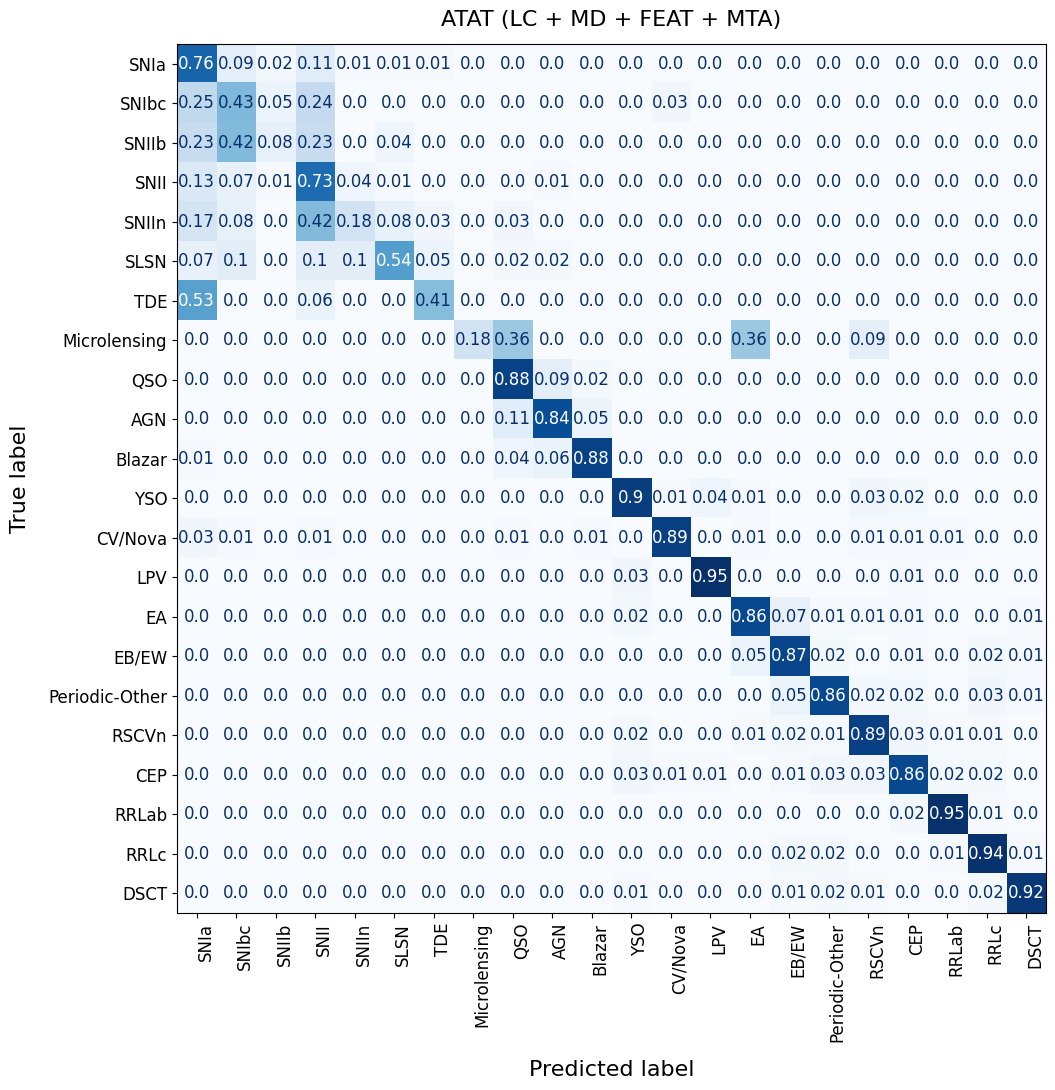

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fs = 12

cm = confusion_matrix(y_true=y_real_test, y_pred=y_pred_test, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(11, 11)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_title('ATAT (LC + MD + FEAT + MTA)', fontsize=16, pad=13)
ax.set_xlabel('Predicted label', fontsize=16, labelpad=13)  # Label del eje x
ax.set_ylabel('True label', fontsize=16, labelpad=13)        # Label del eje y

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import f1_score

f1_score(y_real_test, y_pred_test, average='macro')

0.7235995514922909